# Übung 12

**Gruppenname:**

*TLJ*

Christian Rene Thelen, Artur Less, Karl Johannes

### 12.1 Kernel PCA

In dieser Übung werden wir uns mit der *Kernel PCA* (kPCA) vertraut machen. Dazu werden wir kPCA selbst implementieren und auf einem Datensatz durchführen. Wir werden dabei Gaußsche RBF-Kernel einsetzen.

* Benutzen Sie für diese Übung bitte kein scikit-learn. Implementieren Sie diese Übung mithilfe der Bibliotheken *numpy* und ggf. *scipy*.

**Ihre Aufgaben**

(1) Führen Sie die unten stehende Codezelle aus und visualisieren Sie die Daten. Kodieren Sie dabei die Daten entsprechend ihrer Klassenzugehörigkeit.

In [12]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns

# Your data is here:
X, y = make_moons(n_samples=100, random_state=123)

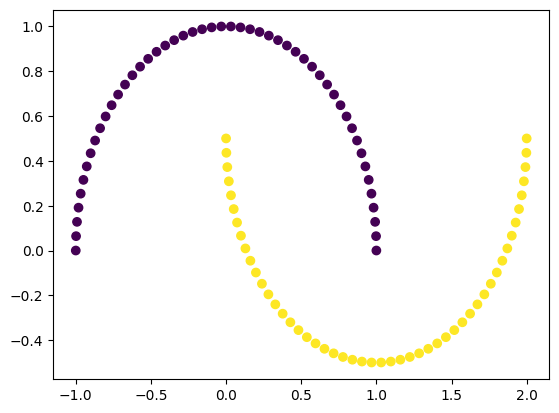

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

(2) Untersuchen Sie die Daten. Beantworten Sie: Wie viele Datenpunkte enthält Ihr Datensatz? Wie viele Features enthält jeder Datenpunkt?

In [14]:
print(f"Der Datensatz enthält {X.shape[0]} Datenpunkte mit je {X.shape[1]} Features.")

Der Datensatz enthält 100 Datenpunkte mit je 2 Features.


(3) Wir werden im Verlauf dieser Übung die Kernel PCA mit Gaußschem RBF-Kernel implementieren und dabei den Faktor $\gamma=15$ verwenden. 

* Schlagen Sie zunächst in den Folien zur Vorlesung nach, wie der Gaußsche RBF Kernel definiert ist (**Achtung:** die Definition unterscheidet sich leicht von der Definition des Kernels, die Sie in einer der vorigen Aufgaben zur PCA verwendet haben).
* Bestimmen Sie dann eine Kernel-Matrix $K$, deren Einträge $K_{ij}=K(\mathbf{x}_i, \mathbf{x}_j)$ entspricht. Diese Matrix soll zunächst noch nicht zentriert sein.

Gaußscher RBF Kernel: $K(x_i, x_j) = \exp(-\gamma || x_i - x_j ||^2$)

In [36]:
from scipy.spatial import distance

def kernel_rbf(x_i: np.ndarray, x_j: np.ndarray, gamma: float) -> np.ndarray:
    """Gaußscher RBF Kernel K(x_i, x_j) mit Parameter gamma."""
    return np.exp(- gamma * (distance.cdist(x_i, x_j, metric='euclidean') ** 2))

(4) Schlagen Sie in den Folien der Vorlesung nach, wie eine Kernel Matrix zentriert wird. Zentrieren Sie anschließend Ihre Kernel-Matrix $K$ aus dem vorherigen Schritt. Wir nennen im Folgenden diese zentrierte Matrix $\tilde{K}$.

Hinweis:

- Nutzen Sie für die Zentrierung die Numpy-Funktion [matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) (oder den entsprechenden @-Operator, sofern Sie diesen Operator bereits kennen).

 Betimmen und zentrieren der Kernelmatrix:
 $$\tilde{K} = K - \mathbf{1}_N K - K \mathbf{1}_n + \mathbf{1}_N K \mathbf{1}_N$$

In [56]:
def center_kernel_matrix(K: np.ndarray, N: int) -> np.ndarray:
    one_over_n = np.array([1/N] * len(K) * len(K)).reshape(K.shape)
    return K - one_over_n @ K - K @ one_over_n + one_over_n @ K @ one_over_n

K = kernel_rbf(X, X, 15)
K_centered = center_kernel_matrix(K, X.shape[0])
K_centered

array([[ 0.92544692, -0.07486869, -0.074737  , ..., -0.06697167,
        -0.0743413 , -0.07471419],
       [-0.07486869,  0.92481383, -0.0748396 , ..., -0.07505922,
        -0.07465785,  0.29984523],
       [-0.074737  , -0.0748396 ,  0.92507897, ..., -0.07492664,
        -0.07193915, -0.07489987],
       ...,
       [-0.06697167, -0.07505922, -0.07492664, ...,  0.92506774,
        -0.0745309 , -0.07490602],
       [-0.0743413 , -0.07465785, -0.07193915, ..., -0.0745309 ,
         0.92587046, -0.07450465],
       [-0.07471419,  0.29984523, -0.07489987, ..., -0.07490602,
        -0.07450465,  0.92512023]])

(5) Führen Sie eine [Eigenwertzerlegung](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) der zentrierten Kernel-Matrix $\tilde{K}$ durch. Wir nennen die Eigenvektoren $\vec{\alpha}_j$ und die assoziierten Eigenwerte $\tilde{\lambda}_j$.

* [Sortieren Sie](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html) die Eigenwerte der Größe nach absteigend und sortieren Sie die assoziierten Eigenvektoren entsprechend.
* Achten Sie auf das Rückgabeformat der Eigenwertzerlegung. Stehen die Eigenvektoren in den Zeilen oder in den Spalten der zurückgegebenen Eigenvektor-Matrix?

Lösen des Eigenwertproblems:
$$
\tilde{K}\alpha_j = \tilde{\lambda}_j \alpha_j
$$

In [50]:
eig_vals, eig_vecs = np.linalg.eig(K_centered)
# [::-1] um die Reihenfolge der Sortierung umzukehren
idx = np.argsort(eig_vals)[::-1]
# eig_vals mit den Zeilen Indizis idx sortieren
# eig_vecs mit idx als Spalten Indizes sortieren und danach erst transponieren 
eig_vals, eig_vecs = eig_vals[idx], (eig_vecs[:, idx]).T
K_centered

array([[ 0.92544692, -0.07486869, -0.074737  , ..., -0.06697167,
        -0.0743413 , -0.07471419],
       [-0.07486869,  0.92481383, -0.0748396 , ..., -0.07505922,
        -0.07465785,  0.29984523],
       [-0.074737  , -0.0748396 ,  0.92507897, ..., -0.07492664,
        -0.07193915, -0.07489987],
       ...,
       [-0.06697167, -0.07505922, -0.07492664, ...,  0.92506774,
        -0.0745309 , -0.07490602],
       [-0.0743413 , -0.07465785, -0.07193915, ..., -0.0745309 ,
         0.92587046, -0.07450465],
       [-0.07471419,  0.29984523, -0.07489987, ..., -0.07490602,
        -0.07450465,  0.92512023]])

(6) Schlagen Sie in der Vorlesung nach, wie die Eigenvektoren normiert werden müssen. Normieren Sie nun die Eigenvektoren und speichern Sie sie als Spalten im Array `scaled_alphas` ab.

Normieren der Eigenvektoren: $$\alpha_j \to \tilde{\alpha_j} = \frac{1}{\sqrt{\tilde{\lambda}_j}} \frac{\alpha_j}{||\alpha_j||}$$

In [48]:
def norm_eig_vecs(eig_vals: np.ndarray, eig_vecs: np.ndarray) -> np.ndarray:
    """Normieren der Eigenvektoren eig_vecs: alpha"""
    return (1 / np.sqrt(eig_vals)) * (eig_vecs / np.linalg.norm(eig_vecs, axis=1))

scaled_alphas = norm_eig_vecs(eig_vals, eig_vecs)
scaled_alphas

/tmp/ipykernel_169045/3666238043.py:3: RuntimeWarning: invalid value encountered in sqrt
  return (1 / np.sqrt(eig_vals)) * (eig_vecs / np.linalg.norm(eig_vecs, axis=1))


array([[ 2.80529300e-02, -5.06674662e-02, -4.81237596e-02, ...,
         5.88532696e+05, -3.44279105e+05,             nan],
       [ 4.75657168e-02,  2.71204259e-02, -4.03246764e-02, ...,
         5.08495941e+05, -5.84333252e+05,             nan],
       [-4.88051888e-02,  2.70757964e-02, -3.98607083e-02, ...,
        -5.14371314e+05, -5.68783553e+05,             nan],
       ...,
       [ 5.62936850e-03,  7.08034470e-02,  5.63421034e-02, ...,
        -4.98686768e+05,  6.49316731e+04,             nan],
       [-7.07747496e-03,  5.98567083e-02,  4.75821798e-02, ...,
         6.23371722e+05,  5.46104559e+04,             nan],
       [-3.76202789e-02, -3.83828605e-02, -3.84290941e-02, ...,
        -4.79419989e+05, -4.78820614e+05,             nan]])

(7) Schlagen Sie in den Folien der Vorlesung nach, wie ein beliebiger Datenpunkt $\mathbf{x}$ auf die $j$-te kPCA Komponente projiziert wird. Implementieren Sie anschließend eine Funktion `proj_x`, die einen Datenpunkt $\mathbf{x}$ sowie den Index der Komponenten $j$, auf den projiziert werden soll, entgegennimmt, und die Projektion des Punktes auf die $j$-te Komponente zurückliefert.

* Hinweis: In dieser Funktion kommen die Werte in `scaled_alphas` zum Einsatz.

In [30]:
def proj_x(x: np.ndarray, idx_j: int) -> np.ndarray:
    K = center_kernel_matrix(kernel_rbf(X, 15), X.shape[0])
    eig_vals, eig_vecs = get_eig_vals(K)
    return np.sum(scaled_alphas[:, idx_j] @ K)

print(eig_vecs)

def kernel(x, y):
    norm = np.linalg.norm(x - y, axis=1) ** 2
    return np.exp(-15 * norm)

def proj_x(x, j):
    return np.sum(scaled_alphas[:, j] * kernel(x, X))

[[ 0.07455287 -0.12640964 -0.12970363 ... -0.00567144 -0.02265767
  -0.09978464]
 [-0.13184362 -0.07057103  0.07045489 ...  0.22042315 -0.11862634
  -0.09944613]
 [-0.12522054  0.10492692 -0.10371965 ...  0.17535112 -0.09440912
  -0.09969111]
 ...
 [ 0.12300381 -0.10627606 -0.10750402 ...  0.04008912  0.15302783
  -0.10103503]
 [-0.07190802  0.12204704 -0.11879925 ...  0.01631505 -0.0092524
  -0.09996374]
 [-0.11916726 -0.1154592   0.11712043 ...  0.15774579 -0.08507648
  -0.09958185]]


(8) Projizieren Sie mit Ihrer Funktion aus Schritt (7) die Daten auf die erste und die zweite kPCA Komponente. Dies sind die Komponenten zu den beiden größten Eigenwerten der zentrierten Kernel-Matrix.

In [31]:
kPCA_1 = scaled_alphas[:, 0].T @ kernel_matrix
kPCA_2 = scaled_alphas[:, 1].T @ kernel_matrix

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

(9) Visualisieren Sie die Daten in den beiden kPCA Komponenten aus Schritt (8). Farbkodieren Sie dabei die Klassenzugehörigkeit.

(10) \[Optional\] Nutzen Sie [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html) `interact`, um eine interaktive Abbildung zu erstellen:

* Mit einem Slider soll der Wert für den Kernel Parameter $\gamma>0$ auswählbar sein.
* Eine Abbildung zeigt die Daten in den ersten beiden kPCA-Komponenten.

Beobachten Sie einen Einfluss des Kernel Parameters auf die Separierbarkeit der beiden Klassen?

### 12.2 Linear Discriminant Analysis (LDA)

In dieser Übung werden wir uns mit der *Linear Discriminant Analysis* (LDA) vertraut machen. Dazu werden wir LDA selbst implementieren und auf einem Datensatz durchführen.

* Benutzen Sie für diese Übung bitte kein scikit-learn. Implementieren Sie diese Übung mithilfe der Bibliotheken *numpy* und ggf. *scipy*.

**Ihre Aufgaben**

(1) Führen Sie die unten stehende Codezelle aus und visualisieren Sie die Daten. Kodieren Sie dabei die Daten entsprechend ihrer Klassenzugehörigkeit.

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Your data is here:
X_12_2 = np.array([[ 4,  2], [ 2,  4], [ 2,  3], [ 3,  6],
              [ 4,  4], [ 9, 10], [ 6,  8], [ 9,  5],
              [ 8,  7], [10,  8]])
y_12_2 = np.hstack((np.ones(5,)*1, np.ones(5,)*2))  # labels

(2) Untersuchen Sie die Daten. Beantworten Sie: Wie viele Datenpunkte enthält Ihr Datensatz? Wie viele Features enthält jeder Datenpunkt?

(3) Schlagen Sie in der Vorlesung nach, wie die *Between Scatter Matrix* $S_b$ definiert ist. Beantworten Sie: Welche Dimensionen wird die *Between Scatter Matrix* für Ihren Datensatz annehmen?

(4) Berechnen Sie $S_b$ für Ihre Daten. Nutzen Sie dafür Numpy-Funktionen.

* Wenn Sie gar nicht weiterkommen, ist hier ein ROT-13 kodierter Tipp: Fvr züffra Zvggryjregr fbjvr rva ähßrerf Cebqhxg (bhgre cebqhpg) orfgvzzra. Fpuyntra Fvr vz Argm anpu, jvr Fvr qvrf zvg Ahzcl orjrexfgryyvtra xöaara.

(5) Schlagen Sie in der Vorlesung nach, wie die *Within Scatter Matrix* $S_w$ definiert ist. Welche Dimensionen wird $S_w$ für Ihre Daten annehmen?

(6) Berechnen Sie $S_w$ für Ihre Daten.

(7) Bestimmen Sie die Matrix $(S_w^{-1}S_b)$ und führen Sie mit *Numpy* eine Eigenwertzerlegung durch.

(8) Identifizieren Sie den größten Eigenwert und dazu den assoziierten Eigenvektor. Wir nennen diesen Eigenvektor $\mathbf{u}_1$.

* Falls Sie Schwierigkeiten haben: Erinnern Sie sich an die Übung zur PCA und daran, wie die Eigenwerte und Eigenvektoren von numpy zurückgegeben werden.

(9) Projizieren Sie die Daten auf den Eigenvektor $\mathbf{u}_1$. Visualisieren Sie die projizierten Daten und kodieren Sie die Klassenzugehörigkeit per Farbe.

* Hinweis zur Visualisierung: Jede Projektion eines Datenpunktes auf $\mathbf{u}_1$ liefert Ihnen einen Skalar. Sie haben es also nach der Projektion mit einem 1-dimensionalen Datensatz zu tun. Sie können
    - [matplotlib](https://matplotlib.org/api/pyplot_api.html) für die Visualisierung verwenden (diesen Befehl kennen Sie schon). In diesem Fall müssen Sie matplotlib noch einen *dummy* Wert für die y-Achse mitgeben.
    - [seaborn](https://seaborn.pydata.org/generated/seaborn.rugplot.html) verwenden, um die Werte darzustellen. Seaborn ist eine Visualisierungsbibliothek, die Matplotlib ergänzt. Bei Seaborn müssen Sie keine *dummy* Werte für die y-Achse erzeugen.

(10) Wiederholen Sie die Schritte (8) und (9) für den Eigenvektor $\mathbf{u}_2$ des zweitgrößten Eigenwerts.

(11) Interpretieren Sie Ihre Visualisierungen aus den Schritten (9) und (10): 

* In welcher Projektion sind die beiden Klassen gut trennbar? 
* Wie könnten Sie einen einfachen Klassifikator definieren, der die Klassen trennen kann? 

(12) \[Optional\] Bauen Sie Ihre Visualisierungen aus Schritten (9) und (10) aus, indem Sie sie Verteilungen der Punkte in den beiden Klassen anzeigen. Diese Verteilungen können Sie per Kerneldichteschätzung bestimmen. Nutzen Sie dafür [Seaborn Distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html).